# Coding Discussion 6
## Alexander Adams
## PPOL564 Data Science 1: Foundations

In [93]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

In [94]:
#Load the training and test data sets
train = pd.read_csv('../train_data.csv')
test = pd.read_csv('../test_data.csv')

In [113]:
train_X

,BEDRM,ROOMS,BATHRM,KITCHENS,HF_BATHRM,FIREPLACES
0,4.0,9.0,3.0,1.0,1.0,0.0
1,3.0,7.0,2.0,1.0,1.0,1.0
2,4.0,9.0,2.0,1.0,2.0,1.0
3,3.0,6.0,1.0,1.0,1.0,0.0
4,4.0,11.0,2.0,1.0,0.0,0.0
...,...,...,...,...,...,...
43585,2.0,5.0,1.0,1.0,0.0,1.0
43586,3.0,7.0,2.0,1.0,1.0,1.0
43587,4.0,9.0,2.0,1.0,0.0,2.0
43588,3.0,6.0,3.0,2.0,1.0,1.0


Having loaded the training and test data sets, first I want to check for missing observations.

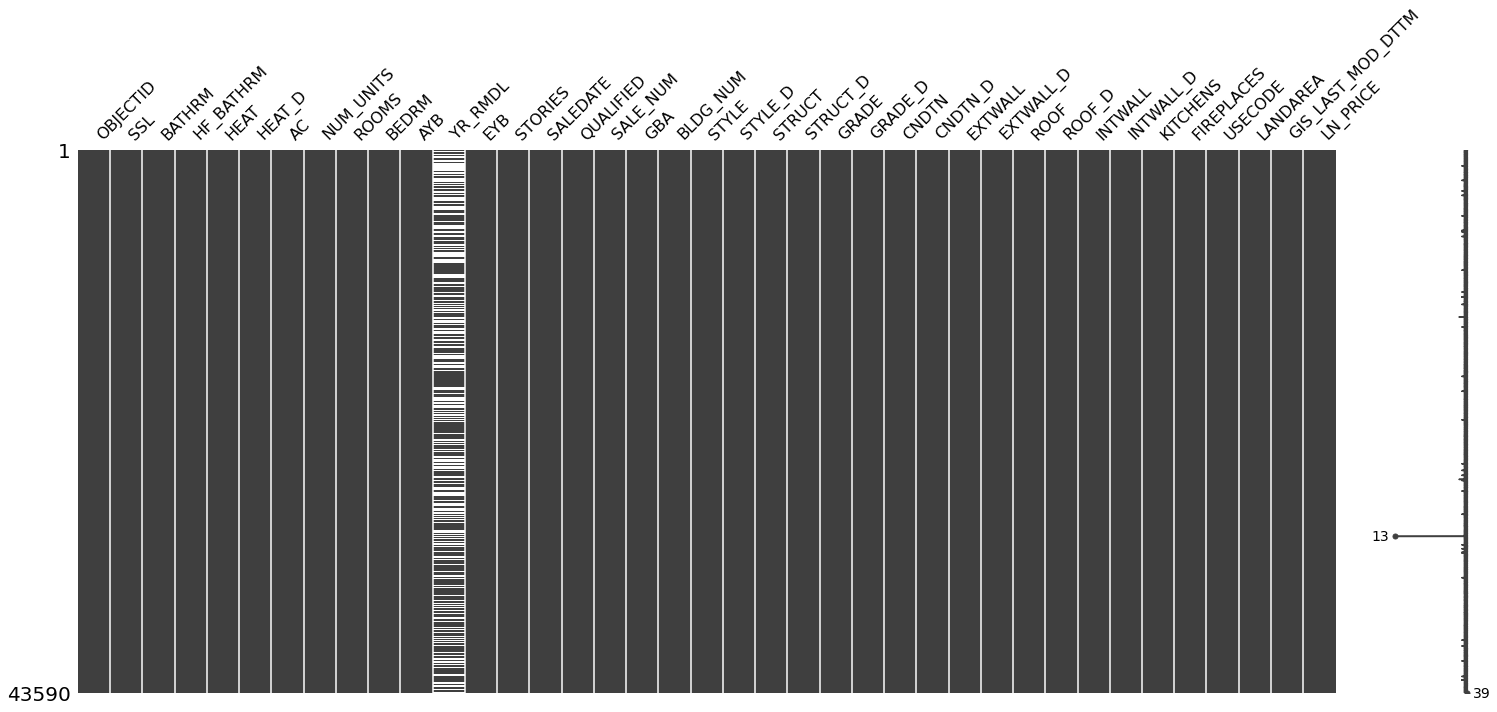

In [99]:
miss.matrix(train)

It looks like the only predictor with missing observations is the year that a house was remodeled, which makes sense since not all houses have been remodeled.

In [114]:
# Drop all observations where the outcome is missing 
train = train[~train.LN_PRICE.isna()]

# Only houses that are sold
train = train[train.LN_PRICE > 0]

In [127]:
train_Y = train['LN_PRICE'] #OUTCOME: log selling price
train['GBA'] = np.log(train['GBA']) #Log the area for scaling purposes
train_X = train[['BEDRM','ROOMS','BATHRM', 'KITCHENS', 'HF_BATHRM', 'FIREPLACES', 'NUM_UNITS', 'STORIES', 'GBA', 'AYB', 'EYB', 'SALE_NUM', 'GRADE', 'CNDTN']] #PREDICTORS: # of Bedrooms, # of Rooms, # of Kitchens, # of Bathrooms

How did I choose which predictors to use? Honestly, I just went with all of the ones which either measured something (like the number of rooms or the year the structure was originally built) or were subjective but ordinal (like grade or condition, where a higher value means a higher grade than a lower value). For the purposes of this assignment, I excluded the categorical, non-ordinal variables (like EXTWALL, which records the material used to construct the exterior walls of a building).

Double check for missing observations:

In [ ]:
train_Y.isnull().sum()

In [132]:
train_X.isnull().sum()

BEDRM         0
ROOMS         0
BATHRM        0
KITCHENS      0
HF_BATHRM     0
FIREPLACES    0
NUM_UNITS     0
STORIES       0
GBA           0
AYB           0
EYB           0
SALE_NUM      0
GRADE         0
CNDTN         0
dtype: int64

train_Y has no missing values, as expected. However, train_X is missing a few. I'm going to replace those values with the mean value for that variable.

In [131]:
#Replace all missing values with the mean
train_X = train_X.fillna(train_X.mean())

In [133]:
#Check for missing values again
train_X.isnull().sum()

BEDRM         0
ROOMS         0
BATHRM        0
KITCHENS      0
HF_BATHRM     0
FIREPLACES    0
NUM_UNITS     0
STORIES       0
GBA           0
AYB           0
EYB           0
SALE_NUM      0
GRADE         0
CNDTN         0
dtype: int64

In [134]:
#Rescale all variables
scaler = pp.MinMaxScaler()
col_names = list(train_X)
train_X = scaler.fit_transform(train_X)

In [135]:
#Turn the scaled variables into a data frame
train_X = pd.DataFrame(train_X,columns=col_names)

Time to test some different models First, specify a consistent method of cross-fold validation to keep results replicable. Also, define a success metric (in this case, mean squared error). 

In [136]:
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

In [137]:
use_metrics = ["neg_mean_squared_error"]

In [138]:
#Run a linear model
lm_scores = cross_validate(LM(),train_X,train_Y, cv = fold_generator, scoring =use_metrics)

#Run a K-Nearest Neighbors model
knn_scores = cross_validate(KNN(),train_X,train_Y, cv = fold_generator, scoring =use_metrics)

#Run a Decision Tree
dt_scores = cross_validate(DTree(),train_X,train_Y, cv = fold_generator, scoring =use_metrics)

#Run a bagging model
bag_scores = cross_validate(Bag(),train_X,train_Y, cv = fold_generator, scoring =use_metrics)

#Run a random forest model
rf_scores = cross_validate(RF(),train_X,train_Y, cv = fold_generator, scoring =use_metrics)

Which model did the best?

In [145]:
#Collect all the mean squared errors into a dictionary 
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

#Convert that dictionary into a data frame and make it tidy
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")

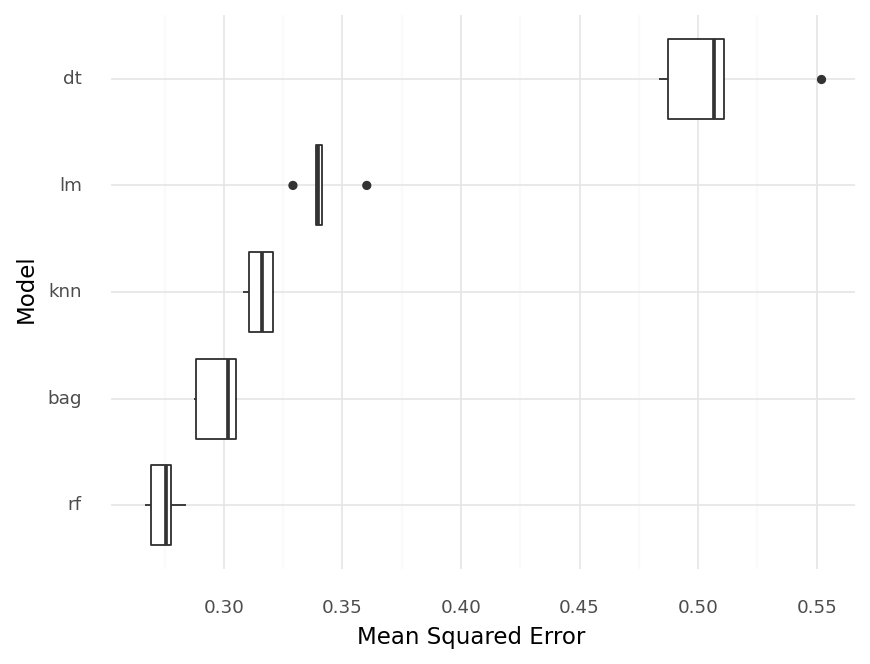

<ggplot: (121974095830)>

In [146]:
#Order the models by average mean squared error
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

#Show the results as a boxplot
(
    ggplot(collect_scores,
          aes(x="Model",y="MSE")) +
    geom_boxplot() +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error") +
    coord_flip() +
    theme_minimal() +
    theme(dpi=150)
)

At this point, before I do any further tuning of various parameters, the random forest model performs the best of the five models. I am curious as to why the decision tree performed so badly; with an average mean squared error greater than 0.5, it's literally less accurate than flipping a coin.

Now, let's see how much more accurate I can make some of these models.

### Tuning!

#### Tune the K-Nearest Neighbors Model

In [149]:
#First get the list of parameters for K-Nearest Neighbors
KNN().get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

This is based in nothing but my own thinking, so maybe it's nonsense, but I'm going to try values of K which are related to the size of my data set. There are 43,588 observations in this training data set, so I am going to try values like 44, 88, 132 (approximately 0.001%, 0.002%, and 0.003% of the data set respectively).

EDIT: I tried those values, and 44 produced the lowest error. I then reduced the range of K values, and am in the process of determining the optimal value for K for this model and this data.

EDIT part 2: I have determined that for this data set and this model, the optimal value for K is 31. Notably, the random forest model outperforms the K nearest neighbors model even when the K value has been optimized.

In [188]:
knn_tune_params = {'n_neighbors':[28, 29, 30, 31, 32, 33, 34, 35, 36, 37]}

In [189]:
#Initialize the GridSearchCV tuner
tune_knn = GridSearchCV(KNN(),knn_tune_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [190]:
#Run the model using the new K values
tune_knn.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=4,
             param_grid={'n_neighbors': [28, 29, 30, 31, 32, 33, 34, 35, 36,
                                         37]},
             scoring='neg_mean_squared_error')

Which one of these parameters did the best, and how well did it do?

In [191]:
tune_knn.best_params_

{'n_neighbors': 31}

In [171]:
#This is a list of the average mean squared errors from before the tuning. If the best score is worse than the original
#score for K-Nearest Neighbors, I need to test other values of K.
orig_scores = collect_scores.groupby('Model').mean()
orig_scores

,MSE
Model,
bag,0.297658
dt,0.508068
knn,0.315323
lm,0.341896
rf,0.274592


In [192]:
tune_knn.best_score_

-0.2893626344271326

#### Tune the Decision Tree Model

In [193]:
#Like before, get the list of parameters
DTree().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [194]:
#Test different depths from 1 to 10
tune_dt = GridSearchCV(DTree(),{'max_depth':[i for i in range(10)]},
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [195]:
#Run the tests
tune_dt.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=4,
             param_grid={'max_depth': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='neg_mean_squared_error')

In [196]:
#Figure out which depth level is optimal
tune_dt.best_params_

{'max_depth': 8}

In [197]:
tune_dt.best_score_

-0.28819964235068724

Observations at this point: 8 is the optimal depth for the decision tree model for this data, and the mean squared error for a decision tree with a depth level of 8 is actually *less* than the mean squared error for a K-Nearest-Neighbors model with a K value of 31 (the optimal value I found earlier)! The decision tree has now gone from being the least accurate model of these five to the most accurate, just by changing this one parameter to the optimal value. Let's see how the random forest does when it's tuned. 

#### Tuning the Random Forest Model

In [198]:
#As before, get the parameter list
RF().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [199]:
#For max features, I changed it to be in accordance with the number of features I am using
rf_params = {'max_depth':[1,2,3],
             'n_estimators':[100,500,1000],
              'max_features': [i for i in range(len(train_X.columns))]} 
tune_rf = GridSearchCV(RF(),rf_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [229]:
#Run, forest, run!
tune_rf.fit(train_X,train_y) 

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'max_depth': [13], 'max_features': [8],
                         'n_estimators': [436, 437, 438]},
             scoring='neg_mean_squared_error')

In [230]:
tune_rf.best_params_

{'max_depth': 13, 'max_features': 8, 'n_estimators': 437}

In [231]:
tune_rf.best_score_

-0.25435168654120416

Interestingly, the best values in this test (depth = 3, features = 8, estimators = 500) produced a mean squared error of 0.33809869527227915, which is less accurate than the default one tested above. I'm going to try some different parameters to optimize this model.

EDIT 1: A depth of 10, 8 features, and 400 estimators produces a mean squared error of 0.2571681538025678, which is more accurate than any other model so far. Let's see how much further we can optimize.

EDIT 2: A depth of 13, 8 features, and 400 estimators produces a mean squared error of 0.2545940945289744.

EDIT 3: Ok, the optimal values for the random forest model are a depth of 13, 8 features, and 437 estimators, which produces a mean squared error of 0.25435168654120416. This is more accurate than any other model I have used.

### Modeling Pipeline

In [232]:
#(1) Choose a number of folds and specify a random state
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

#(2) Specify steps to preprocess the data
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['BEDRM','ROOMS','BATHRM', 
                                                                         'KITCHENS', 'HF_BATHRM', 'FIREPLACES', 
                                                                         'NUM_UNITS', 'STORIES', 'GBA', 'AYB', 
                                                                         'EYB', 'SALE_NUM', 'GRADE', 'CNDTN'])])


#(3) Create the model pipe
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


#(4) Specify the models and their repsective tuning parameters. 
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[31]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[8]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[13],
     'model__max_features':[8],
     'model__n_estimators':[437]},
]


#(5) Combine the search with the pipe
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

#(6)Finally, fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['BEDRM',
                                                                          'ROOMS',
                                                                          'BATHRM',
                                                                          'KITCHENS',
                                                                          'HF_BATHRM',
                                                                          'FIREPLACES',
                                                                          'NUM_UNITS',
                                                                          'STORIES',
                          

In [233]:
#Find the best score:
search.best_score_

-0.2545948670951629

In [234]:
#Which model does the best?
search.best_params_

{'model': RandomForestRegressor(max_depth=13, max_features=8, n_estimators=437),
 'model__max_depth': 13,
 'model__max_features': 8,
 'model__n_estimators': 437}

The random forest model is the most accurate. This makes sense given the parameter tuning I did earlier.

## Run the test data through the pipeline!

Now let's see how this works with the test data., First, some pre-pre-processing.

In [235]:
# Drop all observations where the outcome is missing 
test = test[~test.LN_PRICE.isna()]

# Only houses that are sold
test = test[test.LN_PRICE > 0]

test_Y = test['LN_PRICE'] #OUTCOME: log selling price
test['GBA'] = np.log(test['GBA']) #Log the area for scaling purposes
test_X = test[['BEDRM','ROOMS','BATHRM', 'KITCHENS', 'HF_BATHRM', 'FIREPLACES', 'NUM_UNITS', 'STORIES', 'GBA', 'AYB', 'EYB', 'SALE_NUM', 'GRADE', 'CNDTN']] #PREDICTORS: # of Bedrooms, # of Rooms, # of Kitchens, # of Bathrooms

In [240]:
test_X.isnull().sum()

BEDRM         0
ROOMS         2
BATHRM        0
KITCHENS      0
HF_BATHRM     0
FIREPLACES    1
NUM_UNITS     0
STORIES       7
GBA           0
AYB           1
EYB           0
SALE_NUM      0
GRADE         0
CNDTN         0
dtype: int64

In [243]:
test_X = test_X.fillna(test_X.mean())

In [244]:
test_X.isnull().sum()

BEDRM         0
ROOMS         0
BATHRM        0
KITCHENS      0
HF_BATHRM     0
FIREPLACES    0
NUM_UNITS     0
STORIES       0
GBA           0
AYB           0
EYB           0
SALE_NUM      0
GRADE         0
CNDTN         0
dtype: int64

Great, now let's run the test data through the pipeline.

In [246]:
search.fit(test_X,test_Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['BEDRM',
                                                                          'ROOMS',
                                                                          'BATHRM',
                                                                          'KITCHENS',
                                                                          'HF_BATHRM',
                                                                          'FIREPLACES',
                                                                          'NUM_UNITS',
                                                                          'STORIES',
                          

Which model did the best?

In [247]:
search.best_params_

{'model': RandomForestRegressor(max_depth=13, max_features=8, n_estimators=437),
 'model__max_depth': 13,
 'model__max_features': 8,
 'model__n_estimators': 437}

The random forest regressor was the most accurate model tested. How accurate was it?

In [250]:
print('The Random Forest model produced a mean squared error of', (search.best_score_)*-1, 'when it was applied to the test data.')

The Random Forest model produced a mean squared error of 0.259304512253342 when it was applied to the test data.
